In [1]:
import matplotlib.pyplot as plt
import json

## Data

The data below was collected from DraftKings and then converted to implied probabilities using: https://www.gamingtoday.com/tools/implied-probability/


In [3]:
with open("../data/odds/sb_odds.json", "r") as f:
    data = json.load(f)

### Basic: y = mx + b

In [4]:
import numpy as np
from statistics import mean

def slope_intercept(team):
    xs, ys = np.array([float(k) for k in team.keys()]), np.array([v[1] for v in team.values()])
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

m_b = {
    "chiefs": slope_intercept(data["chiefs"]),
    "niners": slope_intercept(data["niners"])
}


In [5]:
def rnd(v):
    return round(v, 4)


def x_intercept(m, b):
    return -b/m

def get_mx_b(m, b, x_vals):
    return [(m*x)+b for x in x_vals]

print(f"Chiefs: m = {rnd(m_b['chiefs'][0])} b = {rnd(m_b['chiefs'][1])} x-intercept = {rnd(x_intercept(*m_b['chiefs']))}")
print(f"Niners: m = {rnd(m_b['niners'][0])} b = {rnd(m_b['niners'][1])} x-intercept = {rnd(x_intercept(*m_b['niners']))}")


Chiefs: m = 0.0397 b = -0.4319 x-intercept = 10.8682
Niners: m = 0.0373 b = -0.4005 x-intercept = 10.7259


<Figure size 640x480 with 0 Axes>

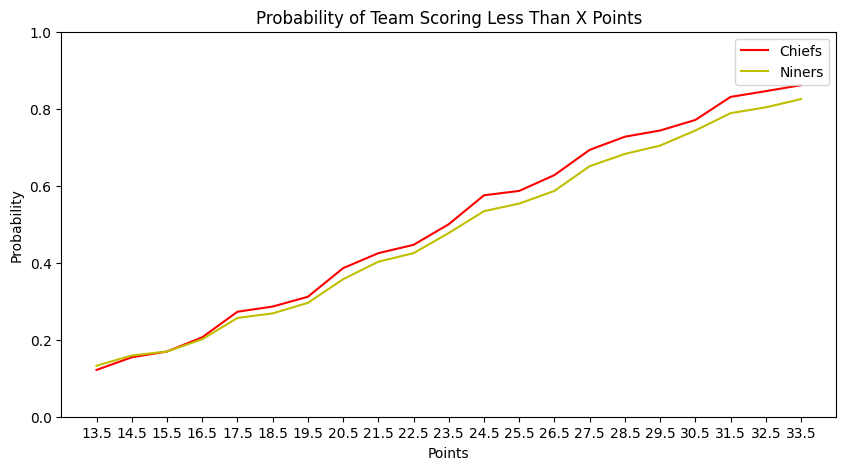

In [73]:

fig = plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for team, team_color in (("chiefs", "r"), ("niners", "y")):
    ax.plot(data[team].keys(), [v[1] for v in data[team].values()], label=team.capitalize(), color=team_color)
    # ax[1].plot(data[team].keys(), get_mx_b(*m_b[team], [float(k) for k in data[team].keys()]), label=f"{team} mx + b")
plt.title("Probability of Team Scoring Less Than X Points")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.xlabel("Points")
plt.legend()
plt.show()

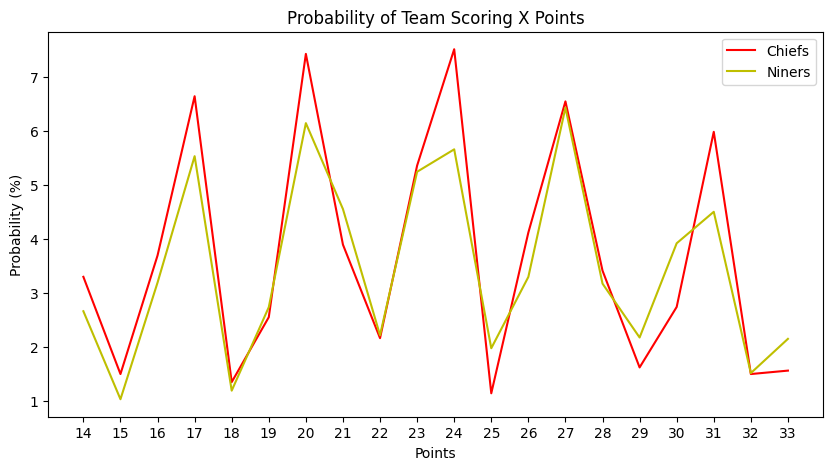

In [133]:
# Plot the Probability of the Team Scoring X Points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
pts = np.arange(14, 34)
for team, team_color in (("chiefs", "r"), ("niners", "y")):
    ax.plot(pts, [p*100 for p in np.diff([v[1] for v in data[team].values()])], label=team.capitalize(), color=team_color)
plt.title("Probability of Team Scoring X Points")
plt.ylabel("Probability (%)")
plt.xlabel("Points")
plt.xticks(pts)
plt.legend()
plt.show()



In [176]:
for t in ["chiefs", "niners"]:
    under_min, over_max = data[t]['13.5'][1]*100, (1 - data[t]['33.5'][1])*100
    in_odds = sum(np.diff([v[1] for v in data[t].values()]))
    print(f"{t.capitalize()}: Less Than 13.5: {under_min:.2f}%, 14 <= X <= 33: {in_odds*100:.2f}%, Greater Than 33.5: {over_max:.2f}%")

Chiefs: Less Than 13.5: 12.14%, 14 <= X <= 33: 73.97%, Greater Than 33.5: 13.88%
Niners: Less Than 13.5: 13.25%, 14 <= X <= 33: 69.26%, Greater Than 33.5: 17.50%


## Next Step: CMFs, CDFs, and PDFs

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, Akima1DInterpolator

def get_cdf_model(team:dict, interpolation_type:str, inverse:bool = False):
    """Build a CDF model from the implied probability of team total odds
    """
    # Removing the "Sportsbook Edge" to get a true probability
    data_less_than = [((float(k)), v[1] - ((v[0] + v[1] - 1) / 2)) for (k,v) in team.items()]
    max_pts, max_offset = max([point[0] for point in data_less_than]), 17

    # Build the CDF from the data
    points         = np.array([0] + [point[0] for point in data_less_than] + [max_pts + max_offset])
    prob_less_than = np.array([0] + [point[1] for point in data_less_than] + [1])
    
    X = prob_less_than if inverse else points
    Y = points if inverse else prob_less_than
    # Choose interpolation method for the CDF
    if interpolation_type in ("linear", "quadratic", "cubic"):
        return interp1d(X, Y, kind=interpolation_type, fill_value=(0, 1), bounds_error=False)
    if interpolation_type == "cubic_spline":
        return CubicSpline(X, Y, bc_type='clamped')
    if interpolation_type == "akima":
        return Akima1DInterpolator(X, Y)

chiefs_models   = {t: get_cdf_model(data["chiefs"], t) for t in ["linear", "quadratic", "cubic", "cubic_spline", "akima"]} 
chiefs_inv_models   = {t: get_cdf_model(data["chiefs"], t, inverse=True) for t in ["linear", "quadratic", "cubic"]}
niners_models   = {t: get_cdf_model(data["niners"], t, inverse=False) for t in ["linear", "quadratic", "cubic"]}
niners_inv_models   = {t: get_cdf_model(data["niners"], t, inverse=True) for t in ["linear", "quadratic", "cubic"]}

models = {
    "chiefs": chiefs_models,
    "niners": niners_models
}
inv_models = {
    "chiefs": chiefs_inv_models,
    "niners": niners_inv_models
}



In [ ]:
chiefs_high_pts = 1 - chiefs_models["linear"](33)
niners_high_pts = 1 - niners_models["linear"](33)
chiefs_low_pts = chiefs_models["linear"](14)
niners_low_pts = niners_models["linear"](14)
print(f"Probability of Scoring More Than 33: Niners = {niners_high_pts} Chiefs = {chiefs_high_pts} [{niners_high_pts + chiefs_high_pts}]")
print(f"Probability of Scoring Less Than 14: Niners = {niners_low_pts} Chiefs = {chiefs_low_pts} [{niners_low_pts + chiefs_low_pts}]")

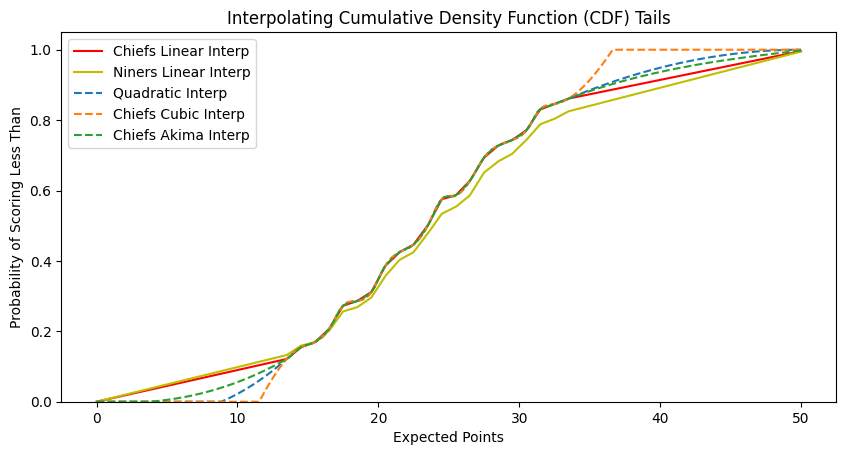

In [154]:
x_high_res      = np.linspace(0, 50, 1000)
linear_vals     = np.clip(chiefs_models["linear"](x_high_res), 0, 1)
niners_linear_vals     = np.clip(niners_models["linear"](x_high_res), 0, 1)
quadratic_vals  = np.clip(chiefs_models["quadratic"](x_high_res), 0, 1)
cubic_vals      = np.clip(chiefs_models["cubic"](x_high_res), 0, 1)
cs_vals         = np.clip(chiefs_models["cubic_spline"](x_high_res), 0, 1)
akima_vals      = np.clip(chiefs_models["akima"](x_high_res), 0, 1)

# Plot the PDF
fig = plt.figure()
fig.set_figwidth(10)
plt.plot(x_high_res, linear_vals, label='Chiefs Linear Interp', color='r')
plt.plot(x_high_res, niners_linear_vals, label='Niners Linear Interp', color='y')
plt.plot(x_high_res, quadratic_vals, label='Quadratic Interp', linestyle='dashed')
plt.plot(x_high_res, cubic_vals, label='Chiefs Cubic Interp', linestyle='dashed')
plt.plot(x_high_res, akima_vals, label='Chiefs Akima Interp', linestyle='dashed')
plt.ylim(bottom=0, top=1.05)
plt.xlabel('Expected Points')
plt.ylabel('Probability of Scoring Less Than')
plt.title('Interpolating Cumulative Density Function (CDF) Tails')
plt.legend()
plt.show()

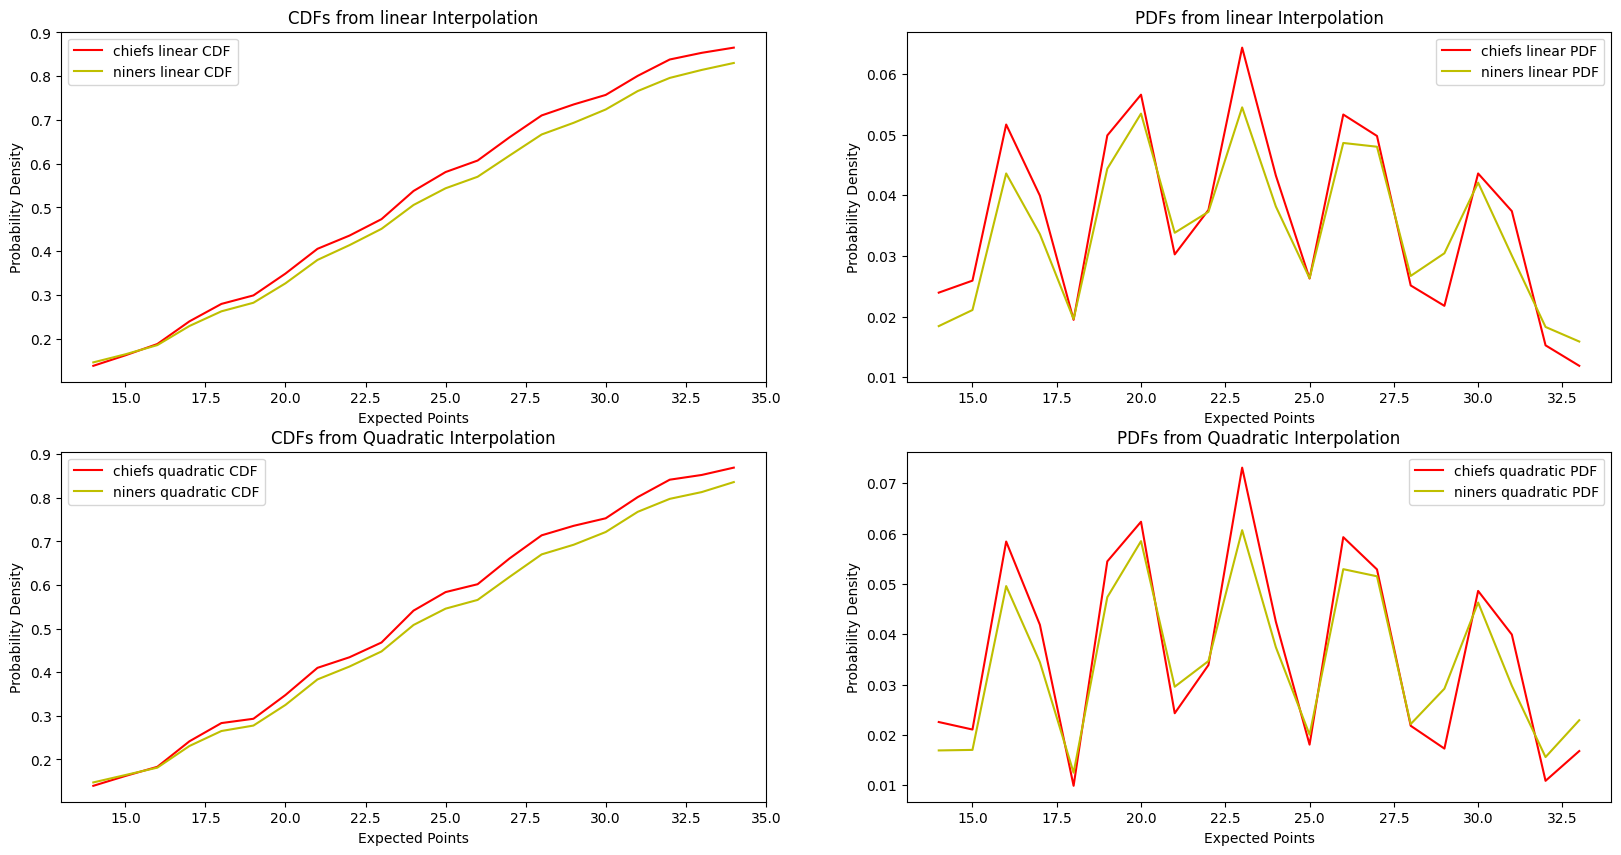

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a high-resolution x-axis range
full_point_total = np.linspace(0, 50, 51)
valid_point_total = np.linspace(14, 34, 21)

# Plot the PDFs
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0][0].set_title("CDFs from linear Interpolation")
ax[0][1].set_title("PDFs from linear Interpolation")
ax[1][0].set_title("CDFs from Quadratic Interpolation")
ax[1][1].set_title("PDFs from Quadratic Interpolation")
for team, color in (("chiefs", 'r'), ("niners", 'y')):
    for i, model in enumerate(["linear", "quadratic"]):
        team_cdf = models[team][model](valid_point_total)
        ax[i][0].plot(valid_point_total, team_cdf, color, label=f"{team} {model} CDF")
        ax[i][1].plot(valid_point_total[:-1], np.diff(team_cdf), color, label=f"{team} {model} PDF")
[a.legend() for a in ax.flatten()]
[a.set_xlabel('Expected Points') for a in ax.flatten()]
[a.set_ylabel('Probability Density') for a in ax.flatten()]
plt.show()


In [161]:
chiefs_linear_pdf    = { k:v for k,v in zip(valid_point_total, np.diff(chiefs_models["linear"](valid_point_total))) }
chiefs_quadratic_pdf = { k:v for k,v in zip(valid_point_total, np.diff(chiefs_models["quadratic"](valid_point_total))) } 
niners_linear_pdf    = { k:v for k,v in zip(valid_point_total, np.diff(niners_models["linear"](valid_point_total))) }
niners_quadratic_pdf = { k:v for k,v in zip(valid_point_total, np.diff(niners_models["quadratic"](valid_point_total))) }
mov_probabilities = {}
for niners_score in valid_point_total[:-1]:
    for chiefs_score in valid_point_total[:-1]:
        if chiefs_score != niners_score:
            score_prob = niners_linear_pdf[niners_score] * chiefs_linear_pdf[chiefs_score]
            margin_of_victory = niners_score - chiefs_score
            if margin_of_victory not in mov_probabilities:
                mov_probabilities[margin_of_victory] = []
            mov_probabilities[margin_of_victory].append((score_prob))

    

Probability Evaluated: 0.4695797057467683
Margin of Victory Expected Value: 0.36847236047743404


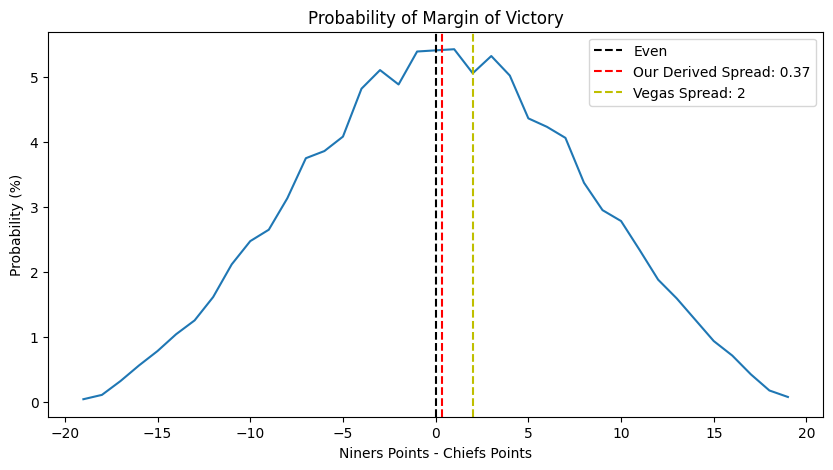

In [162]:

evaluated_prob = sum([sum(probs) for _,probs in mov_probabilities.items()])
print(f"Probability Evaluated: {evaluated_prob}")
expected_value = sum([mov*(sum(probs) / evaluated_prob) for mov,probs in mov_probabilities.items()])
print(f"Margin of Victory Expected Value: {expected_value}")
ordered = sorted(mov_probabilities.items(), key=lambda x: x[0])
plt.figure(figsize=(10, 5))
plt.title("Probability of Margin of Victory")
plt.plot([o for o, _ in ordered], [(sum(probs) / evaluated_prob)*100 for _,probs in ordered])
plt.axvline(0, color='k', linestyle='dashed', label = "Even")
plt.axvline(expected_value, color='r', linestyle='dashed', label = f"Our Derived Spread: {expected_value:.2f}")
plt.axvline(2, color='y', linestyle='dashed', label = "Vegas Spread: 2")
plt.xlabel("Niners Points - Chiefs Points")
plt.ylabel("Probability (%)")
plt.legend()
plt.show()

Probability of Scoring More Than 33: Niners = 0.18568862151443932 Chiefs = 0.14660474716202265 [0.332293368676462]
Probability of Scoring Less Than 14: Niners = 0.145767119905051 Chiefs = 0.13790726817042603 [0.28367438807547707]


In [152]:
chiefs_linear_pdf    = { k:v for k,v in zip(full_point_total, np.diff(chiefs_models["linear"](full_point_total))) }
chiefs_quadratic_pdf = { k:v for k,v in zip(full_point_total, np.diff(chiefs_models["quadratic"](full_point_total))) } 
niners_linear_pdf    = { k:v for k,v in zip(full_point_total, np.diff(niners_models["linear"](full_point_total))) }
niners_quadratic_pdf = { k:v for k,v in zip(full_point_total, np.diff(niners_models["quadratic"](full_point_total))) }
full_mov_probabilities = {}
for niners_score in full_point_total[:-1]:
    for chiefs_score in full_point_total[:-1]:
        if chiefs_score != niners_score:
            score_prob = niners_linear_pdf[niners_score] * chiefs_linear_pdf[chiefs_score]
            margin_of_victory = niners_score - chiefs_score
            if margin_of_victory not in full_mov_probabilities:
                full_mov_probabilities[margin_of_victory] = []
            full_mov_probabilities[margin_of_victory].append((score_prob))

Probability Evaluated: 0.959685967755448
Margin of Victory Expected Value: 0.7423030963472693


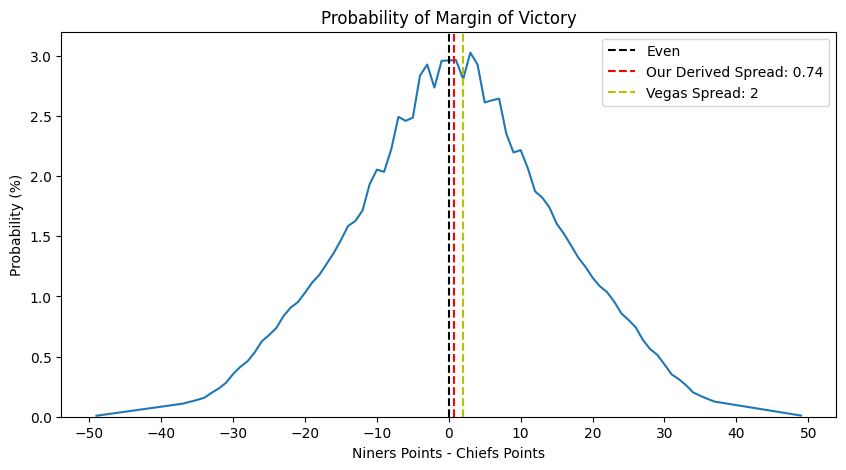

In [158]:
evaluated_prob = sum([sum(probs) for _,probs in full_mov_probabilities.items()])
print(f"Probability Evaluated: {evaluated_prob}")
expected_value = sum([mov*(sum(probs) / evaluated_prob) for mov,probs in full_mov_probabilities.items()])
print(f"Margin of Victory Expected Value: {expected_value}")
ordered = sorted(full_mov_probabilities.items(), key=lambda x: x[0])
plt.figure(figsize=(10, 5))
plt.title("Probability of Margin of Victory")
plt.plot([o for o, _ in ordered], [(sum(probs) / evaluated_prob)*100 for _,probs in ordered])
plt.axvline(0, color='k', linestyle='dashed', label = "Even")
plt.axvline(expected_value, color='r', linestyle='dashed', label = f"Our Derived Spread: {expected_value:.2f}")
plt.axvline(2, color='y', linestyle='dashed', label = "Vegas Spread: 2")
plt.xlabel("Niners Points - Chiefs Points")
plt.xticks(np.arange(-50, 51, 10))
plt.ylabel("Probability (%)")
# Set yaxis
plt.ylim(0, 3.2)
plt.legend()
plt.show()

In [160]:
chiefs_win_prob = sum([sum(probs) for mov,probs in full_mov_probabilities.items() if mov < 0])
niners_win_prob = sum([sum(probs) for mov,probs in full_mov_probabilities.items() if mov > 0])
print(f"Chiefs Win Probability: {(chiefs_win_prob / evaluated_prob) *100}%")
print(f"Niners Win Probability: {(niners_win_prob / evaluated_prob)*100}%")

Chiefs Win Probability: 47.88538280892482%
Niners Win Probability: 52.11461719107522%


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, Akima1DInterpolator

def get_cdf_model(team:dict, interpolation_type:str, inverse:bool = False):
    """Build a CDF model from the implied probability of team total odds
    """
    # Removing the "Sportsbook Edge" to get a true probability
    data_less_than = [((float(k)), v[1] - ((v[0] + v[1] - 1) / 2)) for (k,v) in team.items()]
    max_pts, max_offset = max([point[0] for point in data_less_than]), 10

    # Build the CDF from the data
    points         = np.array([0] + [point[0] for point in data_less_than] + [max_pts + max_offset])
    prob_less_than = np.array([0] + [point[1] for point in data_less_than] + [1])
    
    X = prob_less_than if inverse else points
    Y = points if inverse else prob_less_than
    # Choose interpolation method for the CDF
    if interpolation_type in ("linear", "quadratic", "cubic"):
        return interp1d(X, Y, kind=interpolation_type, fill_value=(0, 1), bounds_error=False)
    if interpolation_type == "cubic_spline":
        return CubicSpline(X, Y, bc_type='clamped')
    if interpolation_type == "akima":
        return Akima1DInterpolator(X, Y)

chiefs_models   = {t: get_cdf_model(data["chiefs"], t) for t in ["linear", "quadratic", "cubic", "cubic_spline", "akima"]} 
chiefs_inv_models   = {t: get_cdf_model(data["chiefs"], t, inverse=True) for t in ["linear", "quadratic", "cubic"]}
niners_models   = {t: get_cdf_model(data["niners"], t, inverse=False) for t in ["linear", "quadratic", "cubic"]}
niners_inv_models   = {t: get_cdf_model(data["niners"], t, inverse=True) for t in ["linear", "quadratic", "cubic"]}

models = {
    "chiefs": chiefs_models,
    "niners": niners_models
}
inv_models = {
    "chiefs": chiefs_inv_models,
    "niners": niners_inv_models
}



In [ ]:
# Build probability distribution from this margin of victory


## The "House Edge"

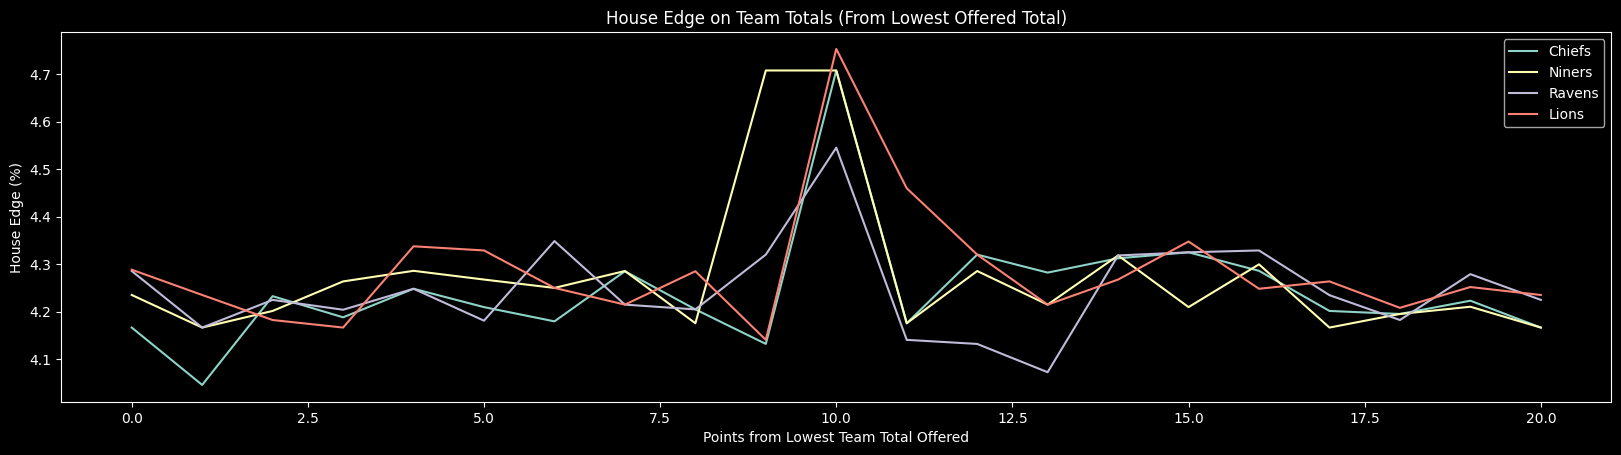

In [216]:
fig = plt.figure()
fig.set_figwidth(20)
plt.plot(range(len(data["chiefs"].values())), [(v[0] + v[1]-1)*100 for v in data["chiefs"].values()], label="Chiefs")
plt.plot(range(len(data["niners"].values())), [(v[0] + v[1]-1)*100 for v in data["niners"].values()], label="Niners")
plt.plot(range(len(data["ravens"].values())), [(v[0] + v[1]-1)*100 for v in data["ravens"].values()], label="Ravens")
plt.plot(range(len(data["lions"].values())),  [(v[0] + v[1]-1)*100 for v in data["lions"].values()],  label="Lions")
plt.legend()
plt.ylabel("House Edge (%)")
plt.xlabel("Points from Lowest Team Total Offered")
plt.title("House Edge on Team Totals (From Lowest Offered Total)")
plt.show()

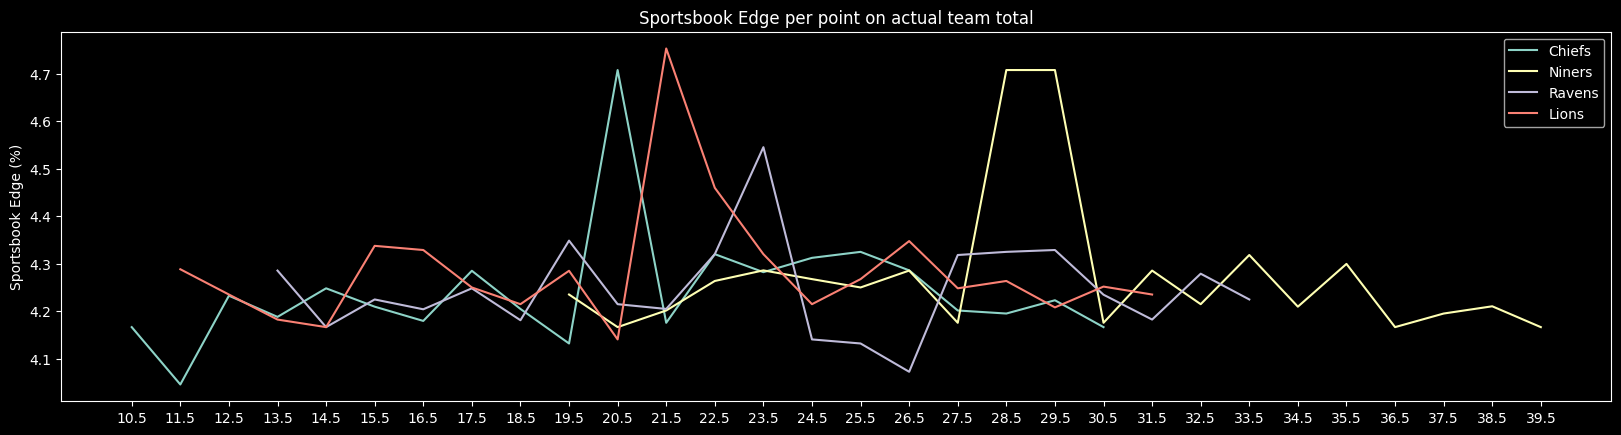

In [217]:
fig = plt.figure()
fig.set_figwidth(20)
plt.plot(data["chiefs"].keys(), [((v[0] + v[1])-1)*100 for v in data["chiefs"].values()], label="Chiefs")
plt.plot(data["niners"].keys(), [((v[0] + v[1])-1)*100 for v in data["niners"].values()], label="Niners")
plt.plot(data["ravens"].keys(), [((v[0] + v[1])-1)*100 for v in data["ravens"].values()], label="Ravens")
plt.plot(data["lions"].keys(),  [((v[0] + v[1])-1)*100 for v in data["lions"].values()], label="Lions")
plt.legend()
plt.ylabel("Sportsbook Edge (%)")
plt.title("Sportsbook Edge per point on actual team total")
plt.show()